<h1 style="color:green; font-family:Georgia">
Machine Learning for MNIST Handwritten digit recognition ::
<hr>
</h1>

<span style = "font-family:Geogia; color:orange;  font-style:italic; font-size:14px">
The MNIST database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. It was created by "re-mixing" the samples from NIST's original datasets. The creators felt that since NIST's training dataset was taken from American Census Bureau employees, while the testing dataset was taken from American high school students, it was not well-suited for machine learning experiments. Furthermore, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels.<br>

The MNIST database contains 60,000 training images and 10,000 testing images. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset. The original creators of the database keep a list of some of the methods tested on it. In their original paper, they use a support-vector machine to get an error rate of 0.8%<br>
</span>

<h5 style="color:red; font-family:Georgia">
total number of images (instances): 70000 <br>
total number of features: 784 (28$\times$28 pixels = 784)
</h5>

<h4 style="color:orange; font-family:Georgia; text-decoration: underline">
Importing importent modules :
</h4>

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 22 22:18:32 2024
@author: mrsag
"""

"""
Importing modules
"""

import numpy as np
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import glob
from Curve_fitting_with_scipy import Gaussianfitting as Gf
from Curve_fitting_with_scipy import Linefitting as Lf
from scipy.signal import fftconvolve
from collections import defaultdict
import PIL
import joblib
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import root_mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, LogisticRegression



import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi'] = 120  # highres display

<h4 style="color:orange; font-family:Georgia;text-decoration: underline">
Defining some required functions :
</h4>

In [2]:
def find_index(array, value):
    # Calculate the absolute differences between each element and the target value
    absolute_diff = np.abs(array - value)
    
    # Find the index of the minimum absolute difference
    index = np.argmin(absolute_diff)
    
    return index


def moving_average(signal, window_size):
    # Define the window coefficients for the moving average
    window = np.ones(window_size) / float(window_size)
    
    # Apply the moving average filter using fftconvolve
    filtered_signal = fftconvolve(signal, window, mode='same')
    
    return filtered_signal


def hist_dataframe(df, bins=10):
    # Define a list of colors for each histogram
    colors = ['red', 'green', 'blue', 'magenta', 'cyan', 'purple', 'orange', 'black']
    # Create subplots with a dynamic number of rows, 3 columns per row
    fig, axes = plt.subplots(nrows=int(np.ceil(len(df.columns) / 3)), ncols=3, figsize=(18, 4.5*int(np.ceil(len(df.columns) / 3))))
    # Flatten the axes array for easy iteration (even if it's a 2D grid)
    axes = axes.flatten()
    
    # Plot each histogram individually
    for i, column in enumerate(df.columns):
        df[column].plot(kind='hist', ax=axes[i], color=colors[i%len(colors)], title=column, bins = bins)
        axes[i].grid(True, linewidth=0.5, color='k')  # Optional: add grid
    
    # Turn off any unused subplots (in case the number of columns is not a multiple of 3)
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])  # Delete empty subplots
    
    plt.tight_layout()  # Adjust the layout
    plt.show()
    pass
    

def binned_mode(data, num_bins):     
    """ use this function to replace the missing value with the most probable value in a dataset...
        There are inbuilt functions for mean and median"""
    # Calculate the range of the data
    data_min, data_max = min(data), max(data)
    
    # Calculate the bin edges
    bins = np.linspace(data_min, data_max, num_bins + 1)
    
    # Group data into bins
    binned_data = defaultdict(list)
    for num in data:
        # Find the correct bin index for each number
        bin_index = np.digitize(num, bins) - 1  # subtract 1 to get 0-based index
        bin_index = min(bin_index, num_bins - 1)  # ensure last bin is included
        binned_data[bin_index].append(num)
    
    # Find the bin with the highest frequency
    most_frequent_bin = max(binned_data, key=lambda k: len(binned_data[k]))
    
    # Calculate the average of the values in the most frequent bin
    mode_value = np.mean(binned_data[most_frequent_bin])
    
    return mode_value


def plot_hollow_pillar_histogram(data, bins=30, edgecolor='black', linewidth=1.5):   #, xlabel='Value', ylabel='Frequency', title='Histogram with Hollow Pillar Bars'):
    """
    Plots a histogram with hollow pillar bars.

    Parameters:
    - data: Array of data to be plotted.
    - bins: Number of bins or bin edges (default is 30).
    - edgecolor: Color of the bar edges (default is 'black').
    - linewidth: Thickness of the bar edges (default is 1.5).
    - xlabel: Label for the x-axis (default is 'Value').
    - ylabel: Label for the y-axis (default is 'Frequency').
    - title: Title for the plot (default is 'Histogram with Hollow Pillar Bars').
    """
    # Create the histogram without plotting it (retrieve the counts and bin edges)
    counts, bin_edges = np.histogram(data, bins=bins)
    # Width of each bar
    bin_width = bin_edges[1] - bin_edges[0]
    # Create the plot
    for i in range(bins):
        plt.hist(bin_edges[i]*np.ones(counts[i]),bins=1, edgecolor='black', linewidth=0.5, rwidth=(max(data)-min(data))/bins)
        
    # Set limits for x and y axis
    # ax.set_xlim(bin_edges[0], bin_edges[-1])
    # ax.set_ylim(0, max(counts) * 1.1)
    # Add labels and title
    # plt.xlabel(xlabel)
    # plt.ylabel(ylabel)
    # plt.title(title)
    pass



def get_numerical_categorical_boolean_columns(data):
    # Separate categorical and numerical columns
    categorical_columns = []
    numerical_columns = []
    boolean_columns = []
    
    for name in np.array(data.columns):
        i=0
        while(data[name][i] is None):
            i += 1

        if(type(data[name][i]) is str):
            categorical_columns.append(name)
        elif((type(data[name][i]) is float) or (type(data[name][i]) is int) or (type(data[name][i]) is bin) or (type(data[name][i]) is np.int64) 
            or (type(data[name][i]) is np.int32) or (type(data[name][i]) is np.int16) or (type(data[name][i]) is np.int8) or 
            (type(data[name][i]) is np.float16) or (type(data[name][i]) is np.float32) or (type(data[name][i]) is np.float64)):
            
            numerical_columns.append(name)
        elif((type(data[name][i]) is bool)):
             boolean_columns.append(name)
        else:
            pass
    return numerical_columns, categorical_columns, boolean_columns

<h3 style="color:red;font-family:Georgia">
Fetching the MNIST Data
</h3>

In [3]:
mnist = fetch_openml("mnist_784")
print(type(mnist))
print(mnist.keys())

<class 'sklearn.utils._bunch.Bunch'>
dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


<h3 style="color:red;font-family:Georgia">
Splitting the data into image and target.
</h3>
<h4 style="color:orange;font-family:Georgia">
As the data is already shuffled, no need to shuffle and split into train and test.<br>
But in general shuffling is needed.
</h4>

dataset shape: (70000, 784)
target shape: (70000,)
image shape: (784,)


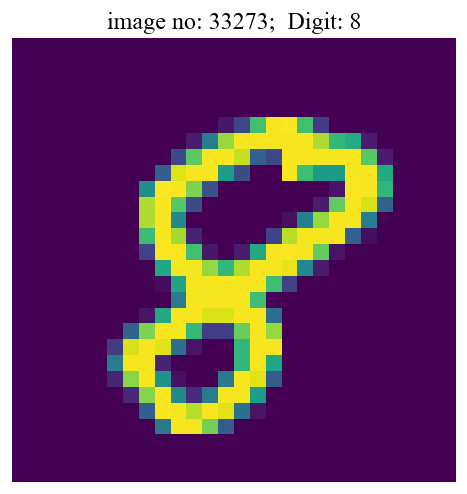

In [4]:
x , y = mnist["data"], mnist['target']
# print(mnist["DESCR"])   # To Show the description
print(f"dataset shape: {x.shape}")
print(f"target shape: {y.shape}")
print(f"image shape: {np.array(x)[0].shape}")

" Showing a random image "
index = np.random.randint(0, 69999)
random_image = np.array((x.iloc[index])).reshape(28,28)
# print(random_image)
plt.imshow(random_image)
plt.axis("off")
plt.title(f"image no: {index};  Digit: {y[index]}")
plt.show()

<h3 style="color:red;font-family:Georgia">
Splitting train and test data
</h3>
<h4 style="color:orange;font-family:Georgia">
As the data is already shuffled, no need to shuffle and split into train and test.<br>
But in general shuffling is needed.
</h4>

In [5]:
# Generate a random permutation of indices to shuffle
shuffle_indices = np.random.permutation(len(y))

# Shuffle the features and target
x = x.iloc[shuffle_indices]
y = y.iloc[shuffle_indices]

train_percent = int(len(y)*0.8)

x_train, y_train = np.array(x[:train_percent]), np.array(y[:train_percent])
x_test, y_test = np.array(x[train_percent:]), np.array(y[train_percent:])

y_train, y_test = y_train.astype(np.int8), y_test.astype(np.int8)

print(f"Train data size: {x_train.shape}\nTest data size: {x_test.shape}")

Train data size: (56000, 784)
Test data size: (14000, 784)


<h3 style="color:red;font-family:Georgia">
Fitting the model: 
</h3>

In [6]:
# model = LogisticRegression()
# model = RandomForestClassifier()
# model = DecisionTreeClassifier()
model = KNeighborsClassifier()
# model = ExtraTreesClassifier()

model.fit(x_train, y_train)
# cross_val_scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)

y_predict = model.predict(x_test)
print(f"accuracy_score: {accuracy_score(y_test, y_predict)*100} %")

accuracy_score: 97.35714285714285 %


<h3 style="color:red;font-family:Georgia">
plotting one random test data
</h3>

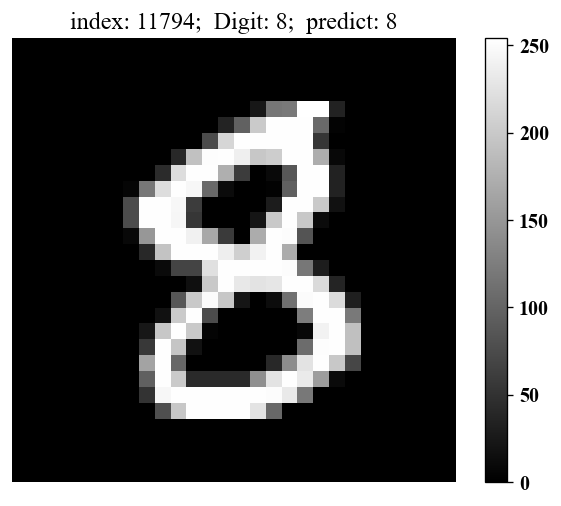

In [7]:
index = np.random.randint(len(y_test)-1)

random_image = np.array((x_test[index])).reshape(28,28)
# print(random_image)
plt.imshow(random_image, cmap='gray')
plt.colorbar()
plt.axis("off")
plt.title(f"index: {index};  Digit: {y_test[index]};  predict: {y_predict[index]}")
plt.show()

<h3 style="color:red;font-family:Georgia">
Checking the prcentage of the incorrect predictions for different digits...
</h3>

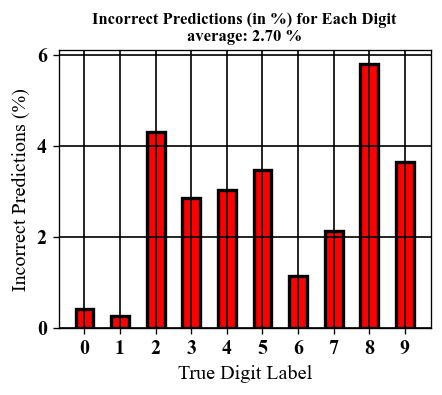

In [8]:
# Identify incorrect predictions
incorrect_indices = np.where(y_test != y_predict)[0]
incorrect_labels = y_test[incorrect_indices]# Extract the corresponding true labels (y_test) for incorrect predictions
total_per_digit = np.bincount(y_test, minlength=10) # Calculate the total occurrences of each digit in the test set
incorrect_per_digit = np.bincount(incorrect_labels, minlength=10)  # Calculate the incorrect occurrences for each digit
percentage_incorrect_per_digit = (incorrect_per_digit / total_per_digit) * 100  # Calculate the percentage of incorrect predictions for each digit

# Plot the percentage of incorrect predictions for each digit
plt.figure(figsize=(4,3))
plt.bar(np.arange(10), percentage_incorrect_per_digit, color='red', edgecolor='black', linewidth = 2, width=0.5)
plt.xticks(np.arange(10))  # Digits 0 to 9
plt.xlabel('True Digit Label')
plt.ylabel('Incorrect Predictions (%)')
plt.title('Incorrect Predictions (in %) for Each Digit\n'+f"average: {np.mean(percentage_incorrect_per_digit):.2f} %", fontsize=10, fontweight='bold')
plt.grid(True, lw=1, color = 'k')
plt.show()


In [9]:
def predict_digit(image_path):
  """
  Loads an image, resizes it to 28x28, flattens it, and predicts the digit using the trained model.

  Args:
    image_path: The path to the image file.

  Returns:
    The predicted digit.
  """
  try:
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    img = img.resize((28, 28))  # Resize to 28x28
    img_array = np.array(img).flatten()  # Flatten the image array
    prediction = model.predict([img_array])[0]  # Predict using the loaded model
    return prediction
  except Exception as e:
    print(f"Error processing image: {e}")
    return None

# Save the function and the model to a joblib file
# joblib.dump((predict_digit, model), 'digit_predictor.joblib') 
# Save the model to a file using joblib
joblib.dump(model, 'digit_predictor.joblib')


['digit_predictor.joblib']